In [1]:
%load_ext autoreload
%autoreload 2

import pickle
from collections import Counter
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

import sys
sys.path.append("..")
from src.data.utils import flatten, parallelize_dataframe
from src.data.scrape_categories import EMOJI_CATEGORIES as emoji_categories
from src.analysis.embedded import calculate_vocabulary_variation
from src.data.cldr import cldr_anns_to_df
from src.visualization.emoji_plotting import plot_emoji_barplot, emoji_scatter
from settings import AMBIGUITY_VARIATION, EMOJI_CATEGORIZED

pd.set_option('mode.chained_assignment', None)

sns.set_color_codes()
sns.set(rc={'figure.figsize':(15, 7)}, font_scale=1.3)
sns.set_style("white", {'axes.grid' : False})

### READ in with pre computed CIs

In [2]:
variations = pd.read_csv(AMBIGUITY_VARIATION)
variations.CIs = variations.CIs.apply(eval)
variations.head()

,emoji,vocabulary,variation,CIs
0,#️⃣,"Counter({'pound': 10, 'number': 9, 'hashtag': ...",0.496355,"[0.34049082708855466, 0.5351314574386924]"
1,*️⃣,"Counter({'asterisk': 11, 'star': 9, 'pound': 2...",0.584016,"[0.3850973823270968, 0.6565330826977255]"
2,©️,"Counter({'copyright': 17, 'copywrite': 3, 'c':...",0.276658,"[0.14734829440712927, 0.41018219388055577]"
3,®️,"Counter({'r': 7, 'registered': 3, 'copyright':...",0.576165,"[0.4251615431142488, 0.6953480601655662]"
4,‼️,"Counter({'exclamation': 11, 'important': 3, 's...",0.494922,"[0.34701899029956806, 0.6155792427859429]"


In [3]:
variations['vocab_size'] = 0
for i, row in variations.iterrows():
    row = row.copy()
    variations.loc[i, "vocab_size"] = len(eval(row.vocabulary).keys())
variations.head()

,emoji,vocabulary,variation,CIs,vocab_size
0,#️⃣,"Counter({'pound': 10, 'number': 9, 'hashtag': ...",0.496355,"[0.34049082708855466, 0.5351314574386924]",6
1,*️⃣,"Counter({'asterisk': 11, 'star': 9, 'pound': 2...",0.584016,"[0.3850973823270968, 0.6565330826977255]",8
2,©️,"Counter({'copyright': 17, 'copywrite': 3, 'c':...",0.276658,"[0.14734829440712927, 0.41018219388055577]",9
3,®️,"Counter({'r': 7, 'registered': 3, 'copyright':...",0.576165,"[0.4251615431142488, 0.6953480601655662]",16
4,‼️,"Counter({'exclamation': 11, 'important': 3, 's...",0.494922,"[0.34701899029956806, 0.6155792427859429]",12


In [4]:
with open(EMOJI_CATEGORIZED, "rb") as f:
    categorized = pickle.load(f)

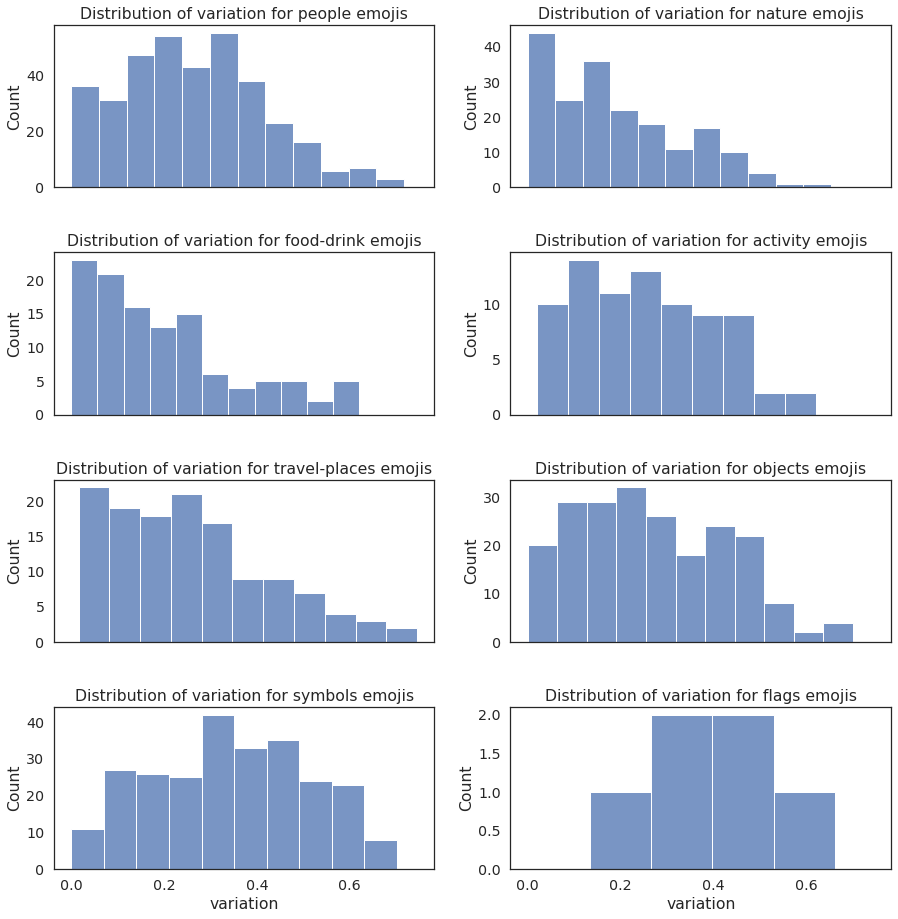

In [5]:
fig, axes = plt.subplots(4, 2, sharex=True)
for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        bins='doane'
        category = emoji_categories[i*2+j]
        if category == 'flags':
            bins = 4
        sns.histplot(data=variations[variations.emoji.isin(categorized[category])].variation,\
                     bins=bins, ax=ax, legend=False)\
            .set_title(f"Distribution of variation for {category} emojis")
plt.subplots_adjust(wspace=0.2, hspace=0.4, top=1.8);

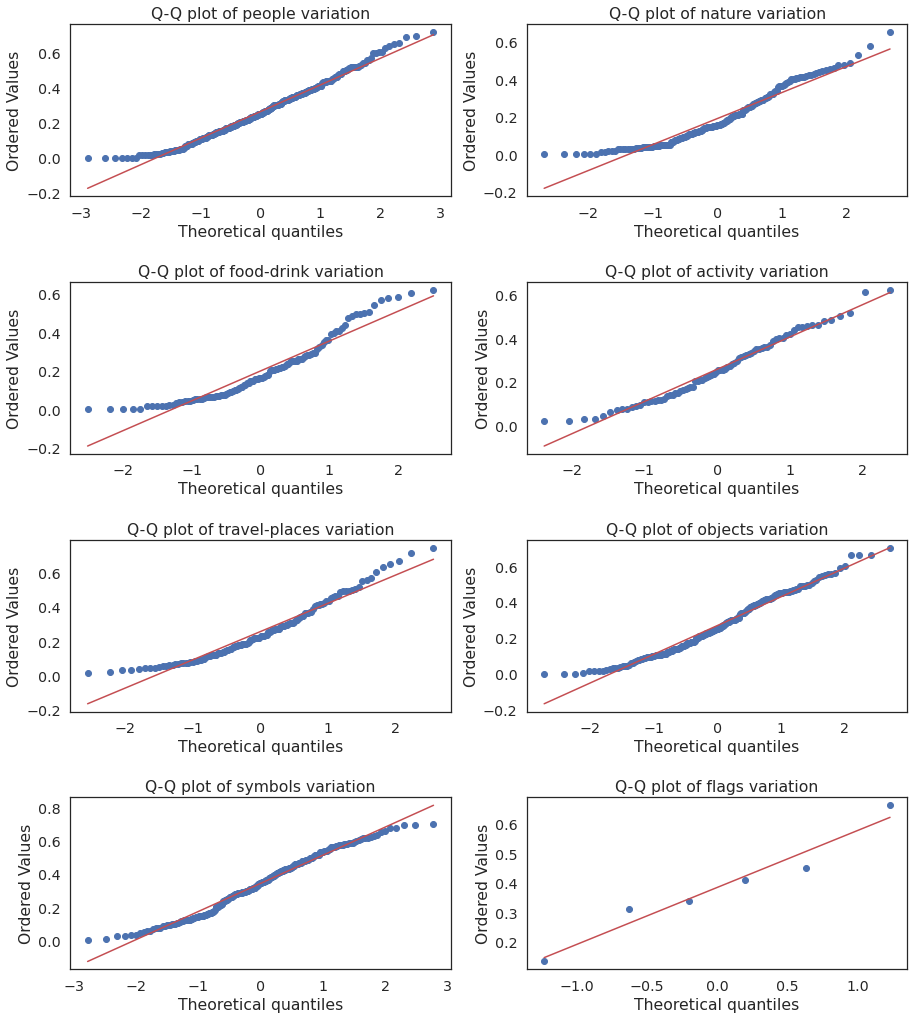

In [6]:
fig, axes = plt.subplots(4, 2)
measurements = np.random.normal(loc=20, scale=5, size=100)   
for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        category = emoji_categories[i*2+j]
        stats.probplot(variations[variations.emoji.isin(categorized[category])].variation,\
                       plot=ax);
        ax.set_title(f"Q-Q plot of {category} variation")
plt.subplots_adjust(wspace=0.2, hspace=0.5, top=2);

### Least and most ambiguous emojis

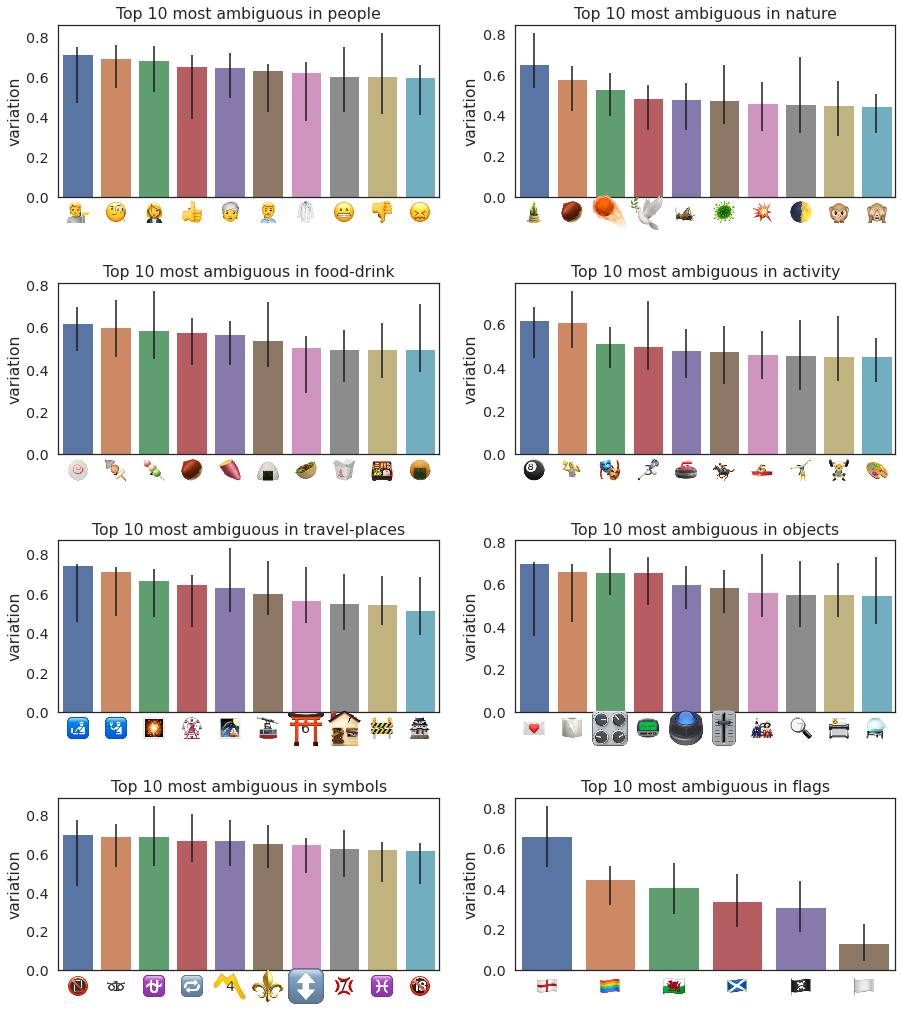

In [7]:
fig, axes = plt.subplots(4, 2)

for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        category = emoji_categories[i*2+j]
        df = variations[variations.emoji.isin(categorized[category])]
        top_ten = df.sort_values("variation", ascending=False)[:10].reset_index()
        plot_emoji_barplot(top_ten, ax, col='variation')
        ax.set_title(f"Top 10 most ambiguous in {category}")
plt.subplots_adjust(wspace=0.2, hspace=0.5, top=2)

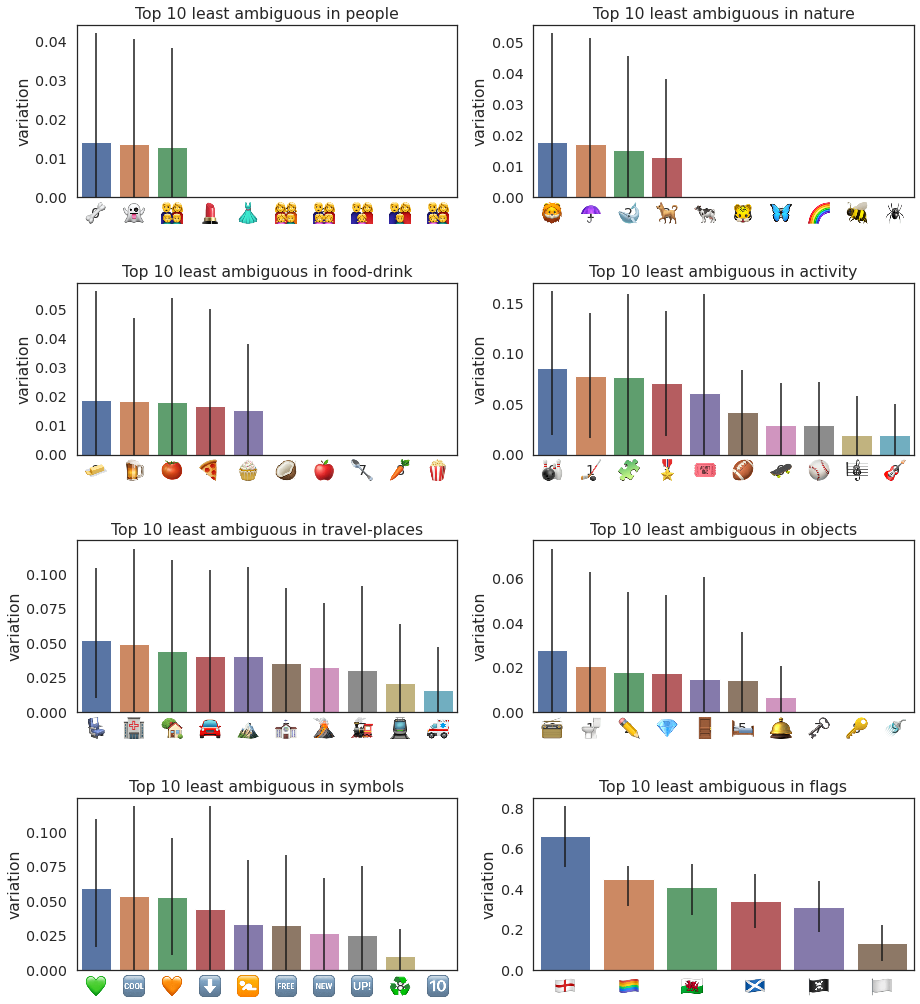

In [8]:
fig, axes = plt.subplots(4, 2)

for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        category = emoji_categories[i*2+j]
        df = variations[variations.emoji.isin(categorized[category])]
        top_ten = df.sort_values("variation", ascending=False)[-10:].reset_index()
        plot_emoji_barplot(top_ten, ax, col='variation')
        ax.set_title(f"Top 10 least ambiguous in {category}")
plt.subplots_adjust(wspace=0.2, hspace=0.5, top=2)

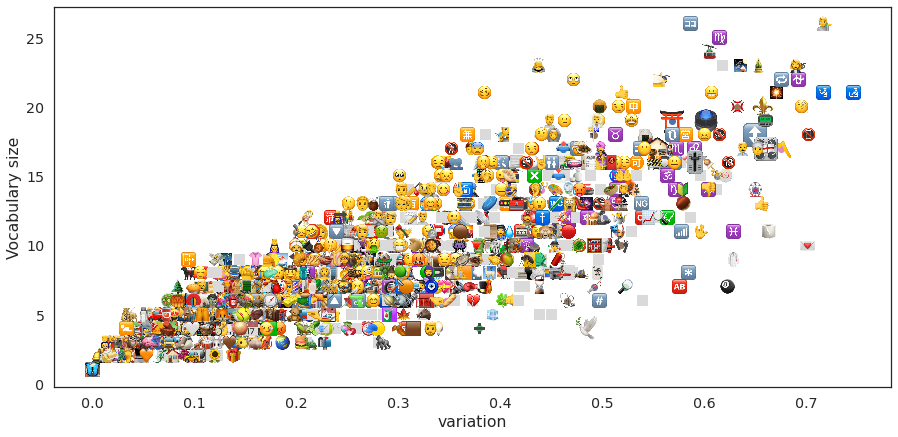

In [9]:
fig, ax = plt.subplots()
df = variations
for x, y, emoji in zip(df['variation'], df['vocab_size'], df['emoji']):
    emoji_scatter(x, y, emoji, zoom=0.2, ax=ax)
    ax.scatter(x, y)
ax.set_xlabel("variation")
ax.set_ylabel("Vocabulary size");

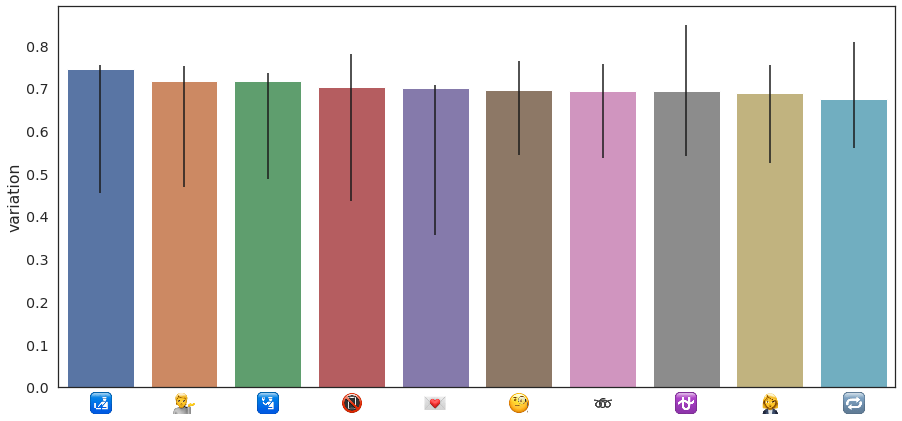

In [10]:
fig, ax = plt.subplots()
top_ten = variations.sort_values(by='variation', ascending=False)[:10].reset_index()
plot_emoji_barplot(top_ten, ax, col='variation')

In [13]:
def assign_category(emoji):
    for category in categorized:
        if emoji in categorized[category]:
            return category

In [15]:
variations["category"] = variations.emoji.apply(assign_category)

In [20]:
variations = variations[variations.category != "flags"]

In [25]:
baseline = 0.6861290227621794
baselines_CIs = [0.5707602351453775, 0.8834659105717826]

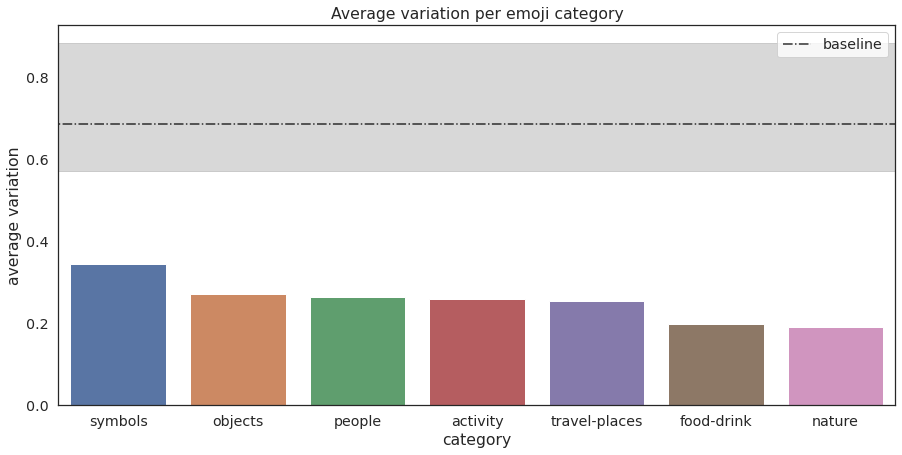

In [30]:
df = variations.groupby("category").variation.mean().sort_values(ascending=False).to_frame().reset_index()

fig, ax = plt.subplots()
ax.plot(range(-2, 12), 14*[baseline], '-.', alpha=0.8, color='black', label='baseline')
ax.fill_between(range(-2, 12), baselines_CIs[0],
                 baselines_CIs[1], alpha = 0.3, color='gray')
sns.barplot(data=df, x='category', y='variation', ax=ax)
ax.set_ylabel("average variation")
ax.set_title("Average variation per emoji category")
ax.legend();

In [38]:
variations[variations.emoji.isin(top_ten.emoji)].category.value_counts()

symbols          4
people           3
travel-places    2
objects          1
Name: category, dtype: int64